#Main Idea Gastrointestinal Cancer Prediction คือ อะไร

##Input VDO and Retrive Image
1. Extract Image from VDO. สามารถกำหนด Time ในการคัดเลือก Frame Image ได้ เช่น ส่งไปในทุกๆ 3 วินาที
2. สร้าง Model Decision Image เลือกภาพที่ดีที่สุดจาก Frame Image เพื่อส่งให้ Model Prediction
3. Retrive Frame Image

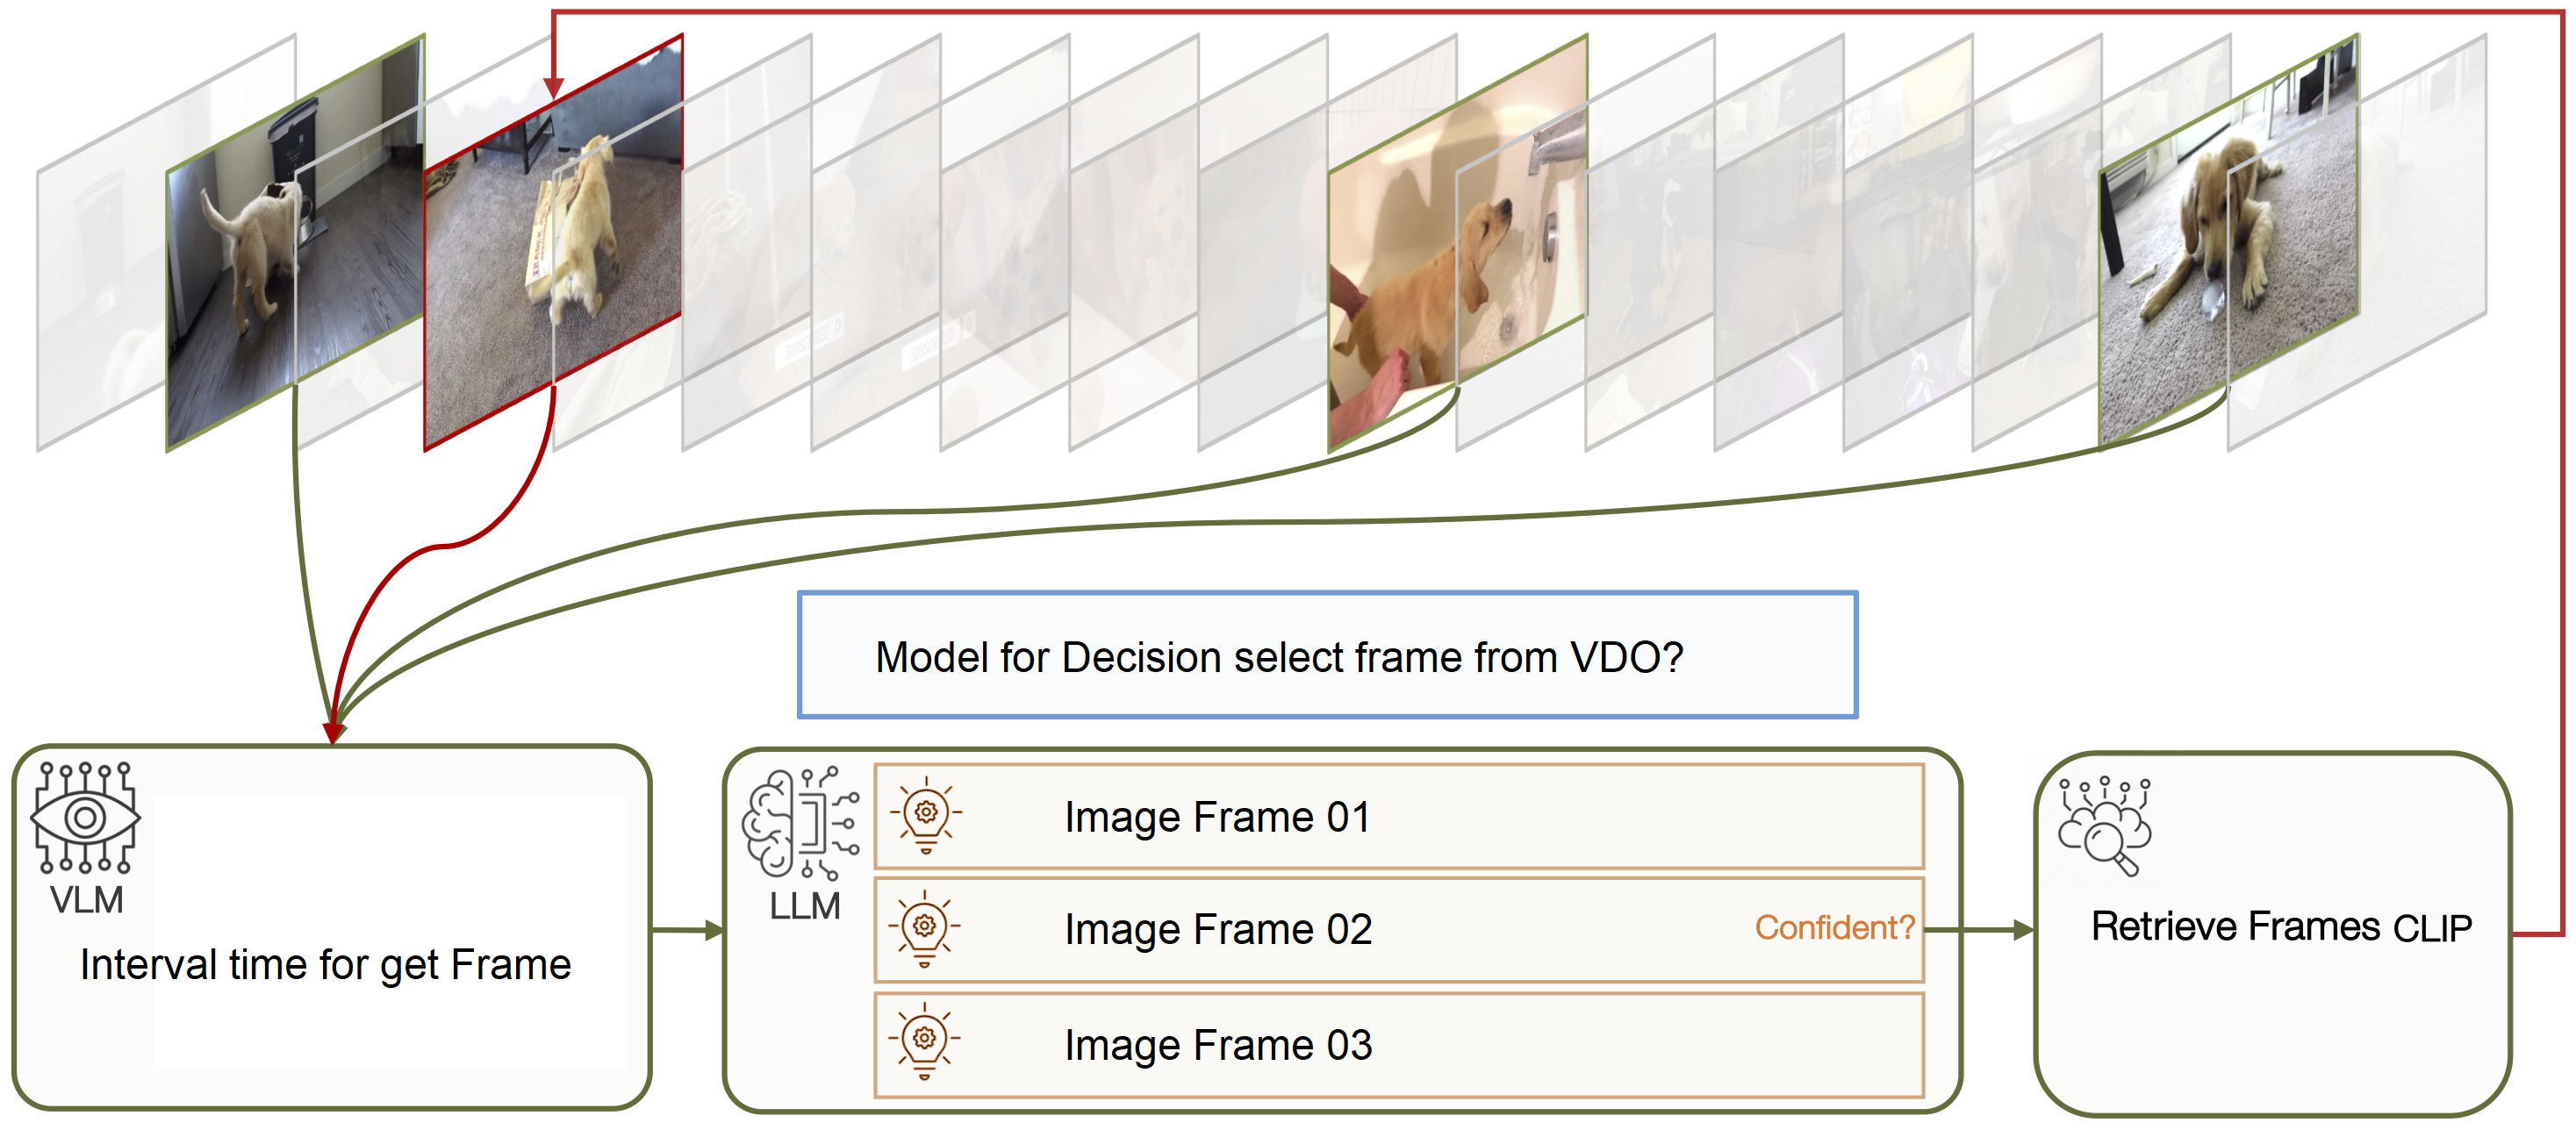


##Data Flow
วิดีโอ → Frame Extraction (≥30 FPS) → Normalization → CADe Model (Detection) → CADx Model (Diagnosis) → Real-Time Overlay (แสดงผลบนหน้าจอแพทย์) → Logging (บันทึกข้อมูล)

ระบบมีส่วนประกอบหลักสามารถแบ่งออกได้เป็น 3 ส่วนหลัก คือ

-	ส่วนประมวลผลวิดีโอ (Input/Pre-Processing)
-	ส่วน Core Model (Model/Engine)
-	ส่วนแสดงผล (Output/Interface)

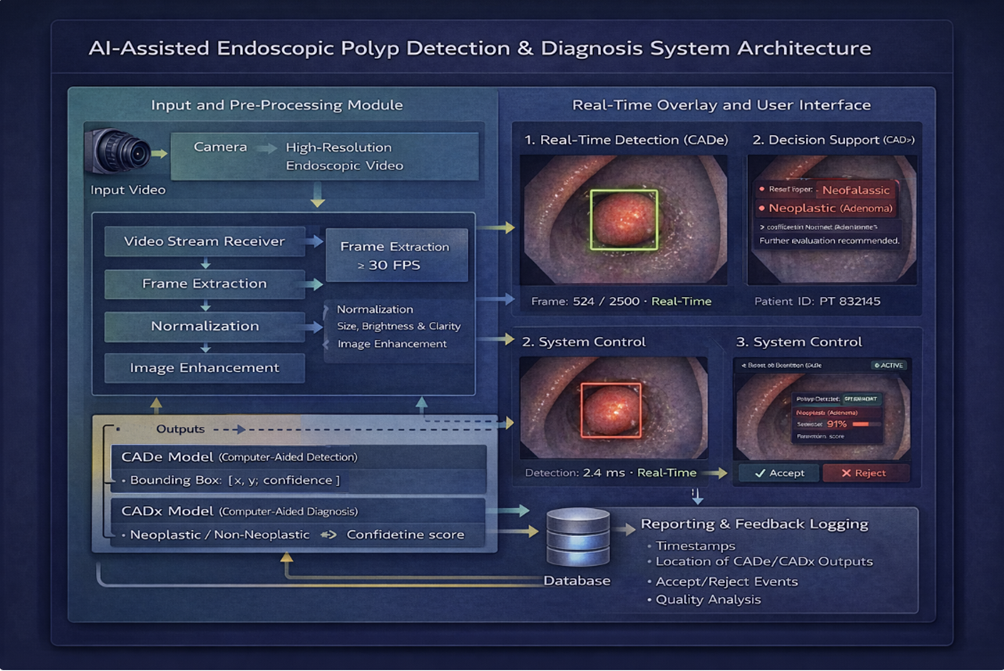


##Prediction
1. Train Model ด้วย Image และ Image label

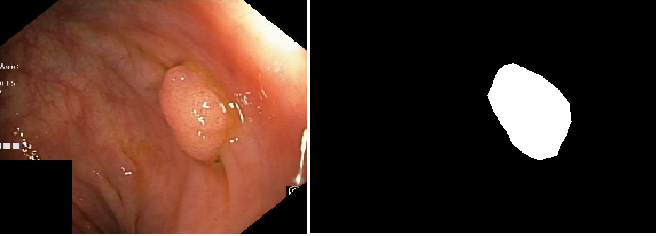

2. ส่ง Image เข้าไป Predicted Mask เพื่อหาจุด Mask ของรอยโรค

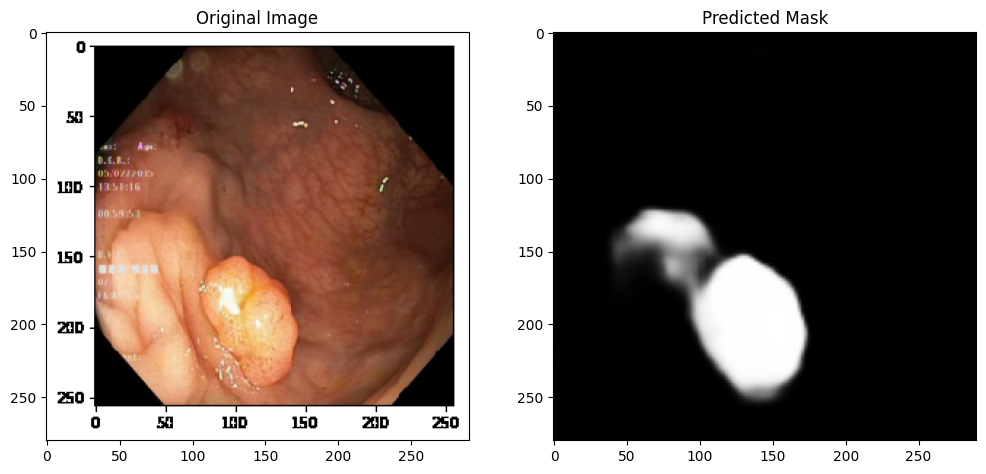

3. นำ Image เข้ามา Overlay ระหว่าง Original Image และ Predicion Mask

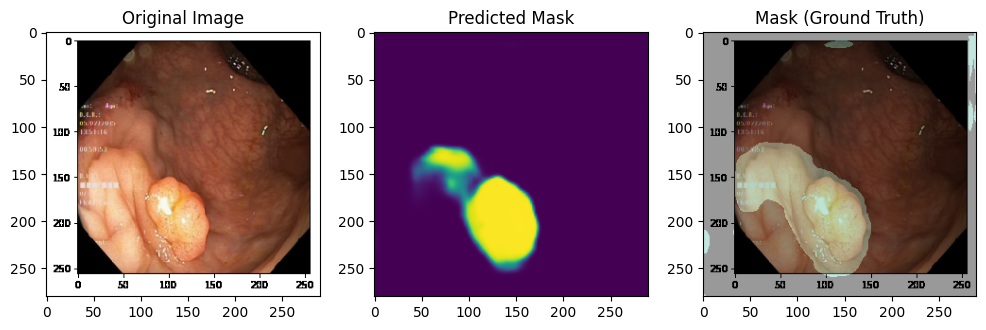


#Install Keras

In [3]:
!pip install tensorflow keras opencv-python

#Import Libary

In [4]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

#1. กำหนด Path ของ Image
- Images สำหรับ Train model
- Image Label สำหรับ Train Model

ตัวอย่างของ Image ที่นำเอามา Train Model

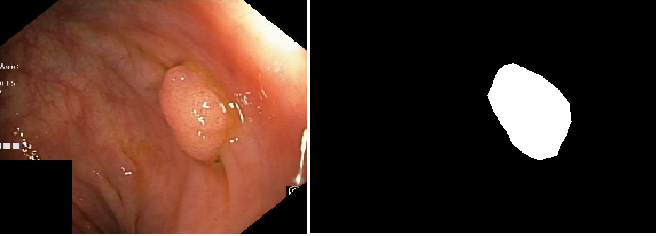


In [5]:
image_dir = '/content/drive/MyDrive/GastrointestinalDataSet/images/'
mask_dir = '/content/drive/MyDrive/GastrointestinalDataSet/masks/'
test_dir = '/content/drive/MyDrive/GastrointestinalDataSet/test/'

images = []
masks = []


for img_name in os.listdir(image_dir):
    img = cv2.imread(os.path.join(image_dir, img_name))
    img = cv2.resize(img, (128, 128))  # Resize to fit model input
    images.append(img)

    mask = cv2.imread(os.path.join(mask_dir, img_name), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (128, 128))
    masks.append(mask)

images = np.array(images) / 255.0  # Normalize images
masks = np.array(masks) / 255.0     # Normalize masks

##สร้าง U-NET Model

In [20]:
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

##Fit Model โดยส่ง Image และ Image lable เข้าไป

In [21]:
history = model.fit(images, masks.reshape(-1, 128, 128, 1), epochs=50)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 590ms/step - accuracy: 0.7478 - loss: 3.5668
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 395ms/step - accuracy: 0.8380 - loss: 0.3992
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 404ms/step - accuracy: 0.8375 - loss: 0.3614
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 403ms/step - accuracy: 0.8424 - loss: 0.3330
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 398ms/step - accuracy: 0.8506 - loss: 0.3257
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step - accuracy: 0.8467 - loss: 0.3325
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.8551 - loss: 0.3156
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 395ms/step - accuracy: 0.8630 - loss: 0.3082
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step - accuracy: 0.8564 - loss: 0.3170
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step - accuracy: 0.8535 - loss: 0.3198
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step - accuracy: 0.8620 - loss: 0.3073
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 13

#สร้าง กราฟ Loss และ Accuracy
กราฟ Loss (ด้านซ้าย): เส้นควรจะ "ดิ่งลง" อย่างรวดเร็วในช่วงแรกและค่อยๆ นิ่งในช่วงปลาย ถ้าเส้นยังหัวทิ่มลงแรงๆ ตอนถึงรอบที่ 50 แปลว่าโมเดลยังเรียนรู้ต่อได้อีก (เพิ่ม Epochs ได้)

กราฟ Accuracy (ด้านขวา): เส้นควรจะ "พุ่งขึ้น" ยิ่งเข้าใกล้ 1.0 (หรือ 100%) เท่าไหร่ยิ่งดีครับ

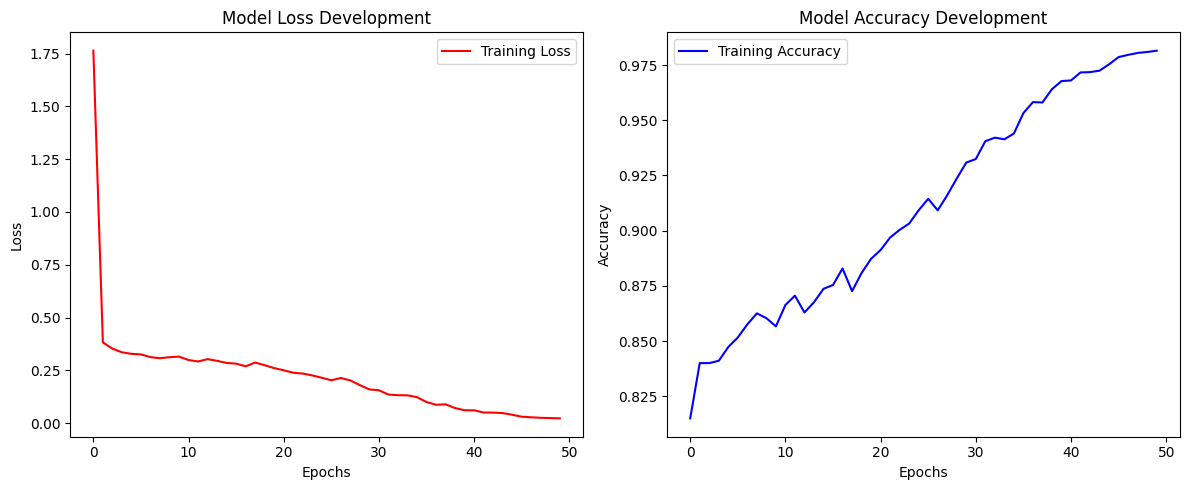

In [22]:
import matplotlib.pyplot as plt

# สร้างพื้นที่สำหรับ 2 กราฟ (Loss และ Accuracy)
plt.figure(figsize=(12, 5))

# --- กราฟที่ 1: Loss (ความผิดพลาด) ---
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.title('Model Loss Development')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# --- กราฟที่ 2: Accuracy (ความแม่นยำ) ---
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.title('Model Accuracy Development')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

##Test Model
โดยการส่ง Image เข้าไปเพื่อให้ Model Prediction mask ตรงรอยของโรค

In [23]:
test_image_path = '/content/drive/MyDrive/GastrointestinalDataSet/test/Test01.jpg'
test_image = cv2.imread(test_image_path)

# Get original dimensions
original_height_of_test_image, original_width_of_test_image = test_image.shape[:2]

# Resize the test image for model input
test_image_resized = cv2.resize(test_image, (128, 128)) / 255.0
test_image_input = np.expand_dims(test_image_resized, axis=0)  # Add batch dimension

# Predict the mask
predicted_mask = model.predict(test_image_input)[0]

# Resize predicted mask to original dimensions
predicted_mask_resized = cv2.resize(predicted_mask.squeeze(), (original_width_of_test_image, original_height_of_test_image))

# Convert predicted mask to uint8 for visualization
predicted_mask_resized_uint8 = (predicted_mask_resized * 255).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


###Plot Image Original and Prediction Mask

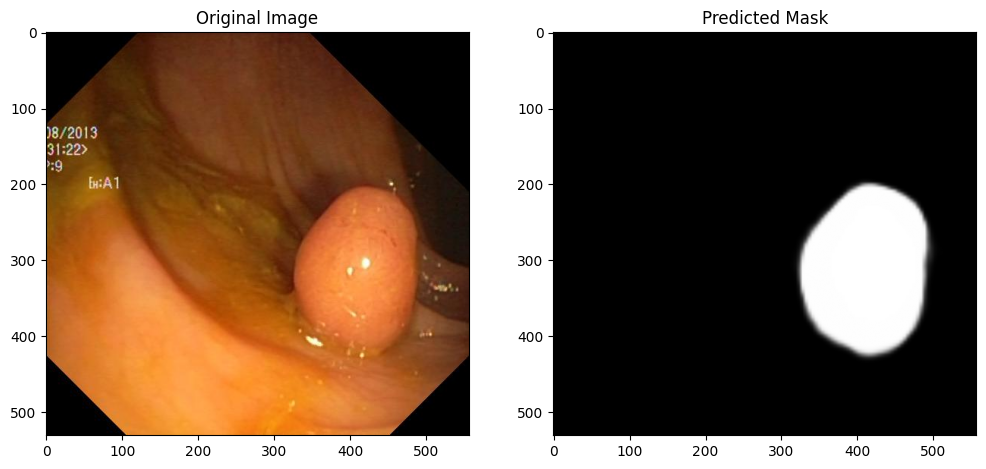

In [24]:
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display

# Predicted Mask
plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask_resized_uint8, cmap="gray")  # Display mask as grayscale

plt.show()

#Prediction จาก Model
- แสดง Original Image
- แสดง Prediction Mask
- แสดง Mask (Ground Truth)

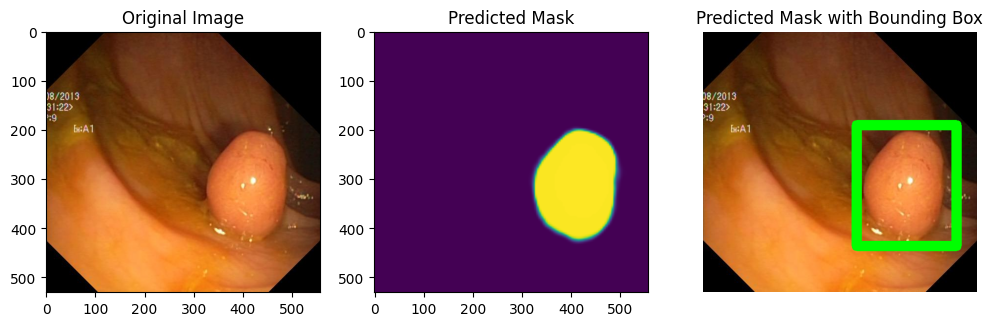

In [25]:
def get_colored_mask(image, mask_image,color = [103,193,173]):
    # `mask_image` is expected to be a single-channel (grayscale) mask here.
    # Create a 3-channel colored version of the mask.
    colored_mask = np.zeros_like(image, dtype=np.uint8) # Create a black image with the same shape as the input image
    # Apply the specified color where the mask_image has non-zero values
    colored_mask[mask_image > 0] = color

    # Blend the original image with the colored mask
    ret = cv2.addWeighted(image, 0.6, colored_mask, 0.4, 0)
    return ret

plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display

# Predicted Mask
plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask_resized_uint8)
#plt.imshow(predicted_mask_resized_uint8, cmap="gray")  # Display mask as grayscale

# Ground Truth Mask
#plt.subplot(1,3,3)
#plt.title('Mask (Ground Truth)')
#plt.imshow(get_colored_mask(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB), predicted_mask_resized_uint8))

image_with_bbox = cv2.cvtColor(test_image.copy(), cv2.COLOR_BGR2RGB)
contours, _ = cv2.findContours(predicted_mask_resized_uint8.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Check if any contours were found
if contours:
    # Find the largest contour (assuming it corresponds to the main segmented object)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box coordinates
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Draw the bounding box on the image
    cv2.rectangle(image_with_bbox, (x, y), (x + w, y + h), (0, 255, 0), 20)  # Green rectangle with thickness 2

    # Display the image with the bounding box
    plt.subplot(1,3,3)
    plt.title("Predicted Mask with Bounding Box")
    plt.imshow(image_with_bbox)
    plt.axis('off')
    plt.show()
else:
    print("No contours found in the predicted mask.")


plt.show()

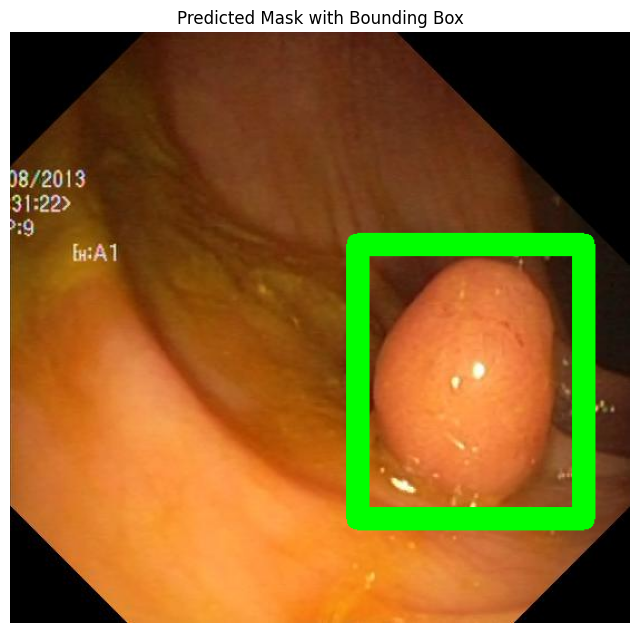

In [26]:
# Create a copy of the original image to draw on
image_with_bbox = cv2.cvtColor(test_image.copy(), cv2.COLOR_BGR2RGB)

# Find contours in the predicted mask
# Use a copy of the mask because findContours modifies the input image in some OpenCV versions
contours, _ = cv2.findContours(predicted_mask_resized_uint8.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Check if any contours were found
if contours:
    # Find the largest contour (assuming it corresponds to the main segmented object)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box coordinates
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Draw the bounding box on the image
    cv2.rectangle(image_with_bbox, (x, y), (x + w, y + h), (0, 255, 0), 20)  # Green rectangle with thickness 2

    # Display the image with the bounding box
    plt.figure(figsize=(8, 8))
    plt.title("Predicted Mask with Bounding Box")
    plt.imshow(image_with_bbox)
    plt.axis('off')
    plt.show()
else:
    print("No contours found in the predicted mask.")


In [27]:
#final_accuracy = history.history['accuracy'][-1]
#print(f"Final Training Accuracy: {final_accuracy:.4f}")

# Confidence can be interpreted in various ways. For a segmentation mask, the pixel values
# themselves represent the model's confidence (probability) that a pixel belongs to the mask.
# We can calculate the mean of these probabilities for an overall confidence score.
mean_predicted_confidence = np.mean(predicted_mask)
print(f"Mean Predicted Mask Confidence: {mean_predicted_confidence:.4f}")

Mean Predicted Mask Confidence: 0.1007


### วิธีทดสอบ API ด้วย Postman

1.  **คัดลอก Public URL:** หลังจากรันเซลล์ด้านบน คุณจะเห็น `Public URL` ปรากฏขึ้นใน Output ให้คัดลอก URL นั้นไว้ (เช่น `https://xxxx-xxxx-xxxx-ngrok-free.app`).

2.  **เปิด Postman:**
    *   สร้าง Request ใหม่ (+ icon).
    *   เลือก Method เป็น `POST`.
    *   วาง `Public URL` ที่คุณคัดลอกมาลงในช่อง URL และเพิ่ม `predict_mask/` ต่อท้าย (เช่น `https://xxxx-xxxx-xxxx-ngrok-free.app/predict_mask/`).

3.  **ตั้งค่า Body:**
    *   ไปที่แท็บ `Body`.
    *   เลือก `form-data`.
    *   เพิ่ม `key` ชื่อ `file`.
    *   เปลี่ยน Type ของ `file` จาก `Text` เป็น `File`.
    *   คลิก `Select Files` และเลือกไฟล์รูปภาพที่คุณต้องการใช้เป็น Input.

4.  **ส่ง Request:** คลิกปุ่ม `Send`

5.  **ตรวจสอบ Response:** คุณควรจะได้รับ JSON Response ที่มี `mask_image_base64` ซึ่งเป็น Base64 encoded string ของ predicted mask และ `message`.

In [31]:
# Run this cell to install necessary libraries
!pip install fastapi uvicorn python-multipart opencv-python-headless Pillow numpy nest_asyncio pyngrok

In [28]:
from fastapi import FastAPI, UploadFile, File

app = FastAPI()

@app.post("/file/")
async def create_upload_file(file: UploadFile = File(...)):
    return {"filename": file.filename}

In [29]:
import io
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import StreamingResponse
import shutil

app = FastAPI()

#@app.post("/upload_and_return_image/")
@app.post("/PredictGastrointestinal/")
async def PredictGastrointestinal(file: UploadFile = File(...)):
    image_data = await file.read()
    image_stream = io.BytesIO(image_data)
    image_stream.seek(0)

    image_bytes = image_stream.getvalue()
    nparr = np.frombuffer(image_bytes, np.uint8)
    image_cv_api = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    original_height_api, original_width_api = image_cv_api.shape[:2]
    test_api_resized = cv2.resize(image_cv_api, (128, 128)) / 255.0
    test_api_input = np.expand_dims(test_api_resized, axis=0)  # Add batch dimension

    # Predict the mask
    predicted_api = model.predict(test_api_input)[0]
    predicted_api_resized = cv2.resize(predicted_api.squeeze(), (original_width_api, original_height_api))
    predicted_api_resized_uint8 = (predicted_api_resized * 255).astype(np.uint8)

    #image_with_bbox_api = cv2.cvtColor(image_cv_api.copy(), cv2.COLOR_BGR2RGB)
    image_with_bbox_api = image_cv_api.copy()
    contours, _ = cv2.findContours(predicted_api_resized_uint8.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Check if any contours were found
    if contours:
        # Find the largest contour (assuming it corresponds to the main segmented object)
        largest_contour = max(contours, key=cv2.contourArea)
        # Get the bounding box coordinates
        x, y, w, h = cv2.boundingRect(largest_contour)
        # Draw the bounding box on the image
        cv2.rectangle(image_with_bbox_api, (x, y), (x + w, y + h), (0, 255, 0), 10)  # Green rectangle with thickness 2

    res, im_png = cv2.imencode(".png", image_with_bbox_api)

    if res:
        # 3. สร้าง BytesIO stream และเขียนข้อมูลลงไป
        image_stream = io.BytesIO(im_png.tobytes())
        # 4. เลื่อน Cursor กลับไปจุดเริ่มต้น (เพื่อให้พร้อมสำหรับการอ่าน/ส่งต่อ)
        image_stream.seek(0)
    else:
        print("Error: ไม่สามารถ Encode ภาพได้")

    return StreamingResponse(image_stream, media_type=file.content_type)

In [32]:
import nest_asyncio
nest_asyncio.apply() # Apply nest_asyncio to allow nested event loops

from pyngrok import ngrok
from google.colab import userdata
import uvicorn

ngrok.kill()

NGROK_AUTH_TOKEN = '3741jSkdnSpnPZUqiCIChlXQrfZ_2MDeGbGUeBAuQFsrpqSCC'
if NGROK_AUTH_TOKEN:
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)
else:
    print("Warning: NGROK_AUTH_TOKEN not found in Colab Secrets. Please add it for ngrok to work.")
    print("You can also set it directly: ngrok.set_auth_token(\"YOUR_AUTH_TOKEN_HERE\")")

ngrok_tunnel = ngrok.connect(8000)
print(f"Public URL: {ngrok_tunnel.public_url}")

config = uvicorn.Config(app, host="0.0.0.0", port=8000, loop="asyncio")
server = uvicorn.Server(config)
#uvicorn.run(app, host="0.0.0.0", port=8000)
await server.serve()

INFO:     Started server process [287]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


Public URL: https://myrtie-mitochondrial-jina.ngrok-free.dev


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [287]
